### Lab: Logistic Regression

**Task:** In order to optimize our inventory, we would like to know which films will be 
      rented next month and we are asked to create a model to predict it.
      
The target variable will be binary: rented (1) or not rented (0)

### 1- Import libraries

In [34]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

import getpass 
password = getpass.getpass()

connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)

········


### 2- Import data and load into dataframe

Create an SQL query or queries to extract the information you think may be relevant for building the prediction model. It should include some film features and some rental features

In [78]:
query = '''select distinct(f.film_id), f.title, f.release_year, f.rental_rate, f.rental_duration, f.length, f.replacement_cost, f.rating, fc.name as category
            from sakila.film f
            join sakila.film_category c
            on f.film_id = c.film_id
            join category fc 
            on c.category_id = fc.category_id'''

In [79]:
df = pd.read_sql_query(query, engine)
df

,film_id,title,release_year,rental_rate,rental_duration,length,replacement_cost,rating,category
0,19,AMADEUS HOLY,2006,0.99,6,113,20.99,PG,Action
1,21,AMERICAN CIRCUS,2006,4.99,3,129,17.99,R,Action
2,29,ANTITRUST TOMATOES,2006,2.99,5,168,11.99,NC-17,Action
3,38,ARK RIDGEMONT,2006,0.99,6,68,25.99,NC-17,Action
4,56,BAREFOOT MANCHURIAN,2006,2.99,6,129,15.99,G,Action
...,...,...,...,...,...,...,...,...,...
995,931,VALENTINE VANISHING,2006,0.99,7,48,9.99,PG-13,Travel
996,977,WINDOW SIDE,2006,2.99,3,85,25.99,R,Travel
997,981,WOLVES DESIRE,2006,0.99,7,55,13.99,NC-17,Travel
998,988,WORKER TARZAN,2006,2.99,7,139,26.99,R,Travel


Set film_id as index

In [89]:
df = df.set_index('film_id')
df

,rental_rate,rental_duration,length,replacement_cost,rating,category
film_id,,,,,,
19,0.99,6,113,20.99,PG,Action
21,4.99,3,129,17.99,R,Action
29,2.99,5,168,11.99,NC-17,Action
38,0.99,6,68,25.99,NC-17,Action
56,2.99,6,129,15.99,G,Action
...,...,...,...,...,...,...
931,0.99,7,48,9.99,PG-13,Travel
977,2.99,3,85,25.99,R,Travel
981,0.99,7,55,13.99,NC-17,Travel


### 3- Prepare data for the model

Analyze extracted features and transform them. You may need to encode some categorical variables, or scale numerical variables*

**3.1 Explore and Clean Data**

In [90]:
df.shape

(1000, 6)

In [91]:
df.dtypes

rental_rate         float64
rental_duration       int64
length                int64
replacement_cost    float64
rating               object
category             object
dtype: object

In [92]:
df.describe()

,rental_rate,rental_duration,length,replacement_cost
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,2.980000,4.985000,115.272000,19.984000
std,1.646393,1.411654,40.426332,6.050833
min,0.990000,3.000000,46.000000,9.990000
25%,0.990000,4.000000,80.000000,14.990000
50%,2.990000,5.000000,114.000000,19.990000
75%,4.990000,6.000000,149.250000,24.990000
max,4.990000,7.000000,185.000000,29.990000


In [93]:
df.isna().sum()

rental_rate         0
rental_duration     0
length              0
replacement_cost    0
rating              0
category            0
dtype: int64

**Check uniques in categorical data**

In [94]:
for col in df.select_dtypes('object'):
    print(df[col].value_counts(), '\n') 

PG-13    223
NC-17    210
R        195
PG       194
G        178
Name: rating, dtype: int64 

Sports         74
Foreign        73
Family         69
Documentary    68
Animation      66
Action         64
New            63
Drama          62
Sci-Fi         61
Games          61
Children       60
Comedy         58
Travel         57
Classics       57
Horror         56
Music          51
Name: category, dtype: int64 



- high variations, no null values etc. 
- no major cleaning necessary
- but drop title, as not needed (only unique values)

In [86]:
df = df.drop(['title'], axis=1)

**Check uniques in numerical data**

In [95]:
for col in df.select_dtypes(np.number):
    print(df[col].value_counts(), '\n')

0.99    341
4.99    336
2.99    323
Name: rental_rate, dtype: int64 

6    212
3    203
4    203
5    191
7    191
Name: rental_duration, dtype: int64 

85     17
179    13
112    13
84     13
100    12
       ..
81      3
95      2
66      2
55      2
96      2
Name: length, Length: 140, dtype: int64 

20.99    57
12.99    55
21.99    55
13.99    55
22.99    55
27.99    53
29.99    53
14.99    51
19.99    50
10.99    49
11.99    49
17.99    47
26.99    46
23.99    45
25.99    43
18.99    42
28.99    41
9.99     41
16.99    38
24.99    38
15.99    37
Name: replacement_cost, dtype: int64 



- removing columns realease_year as there no variation (only 1 value for all rows)

In [88]:
df = df.drop(['release_year'], axis=1)

**3.2 EDA**

**Correlation matrix of numerical data**

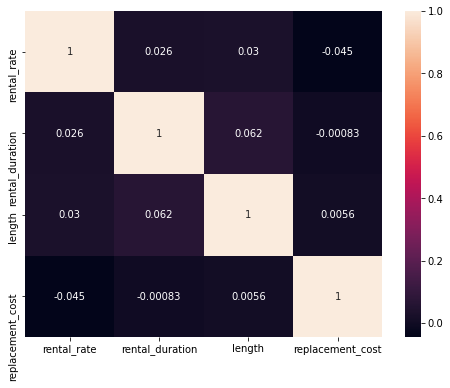

In [96]:
corr_matrix=df.corr()
fig, ax = plt.subplots(figsize=(8, 6))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

==> no really high correlations, no deletions necessary

**Distribution of numerical columns**

c:\users\anton\appdata\local\programs\python\python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


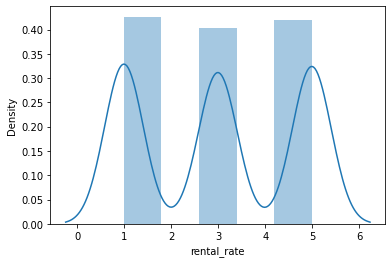

c:\users\anton\appdata\local\programs\python\python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


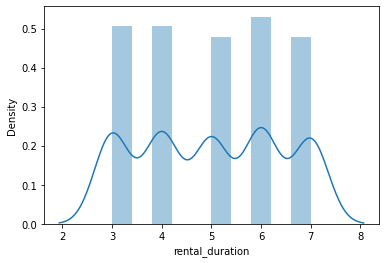

c:\users\anton\appdata\local\programs\python\python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


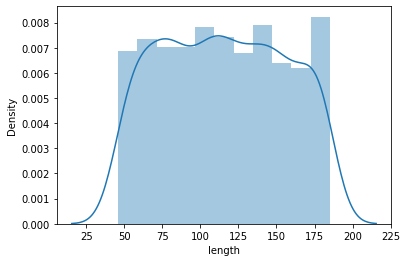

c:\users\anton\appdata\local\programs\python\python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


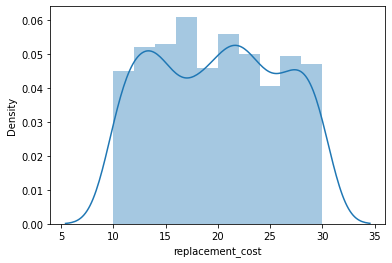

In [97]:
for col in df.select_dtypes(np.number):
    sns.distplot(df[col])
    plt.show()

- use rental_duration, rental_rate as categoricals? 
Would that be better? But afterwards I would get dummies and just convert it back into numbers, right?

**Encode categorical data**

Create Copy of Dataframe

In [99]:
df1 = df
df1

,rental_rate,rental_duration,length,replacement_cost,rating,category
film_id,,,,,,
19,0.99,6,113,20.99,PG,Action
21,4.99,3,129,17.99,R,Action
29,2.99,5,168,11.99,NC-17,Action
38,0.99,6,68,25.99,NC-17,Action
56,2.99,6,129,15.99,G,Action
...,...,...,...,...,...,...
931,0.99,7,48,9.99,PG-13,Travel
977,2.99,3,85,25.99,R,Travel
981,0.99,7,55,13.99,NC-17,Travel


Get dummies for categoricals

In [100]:
X = pd.get_dummies(df1, columns=['rating','category'])
X

,rental_rate,rental_duration,length,replacement_cost,rating_G,rating_NC-17,rating_PG,rating_PG-13,rating_R,category_Action,...,category_Drama,category_Family,category_Foreign,category_Games,category_Horror,category_Music,category_New,category_Sci-Fi,category_Sports,category_Travel
film_id,,,,,,,,,,,,,,,,,,,,,
19,0.99,6,113,20.99,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
21,4.99,3,129,17.99,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
29,2.99,5,168,11.99,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
38,0.99,6,68,25.99,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
56,2.99,6,129,15.99,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
931,0.99,7,48,9.99,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
977,2.99,3,85,25.99,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
981,0.99,7,55,13.99,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### 4- Work on Target Variable

Create a query to get the list of films and a boolean indicating if it was rented last month. 
This would be our target variable.

**Import Data**

In [103]:
query1 = '''with cte1 as 
	(select i.film_id, date_format(convert(r.rental_date, date), '%%Y-%%m') as last_rental
                    from rental r
                    join inventory i
                    on i.inventory_id = r.inventory_id
                    group by rental_date, film_id
                    having last_rental = "2006-02")
                    
	select f.film_id, c.last_rental
        from film f
        left join cte1 c
        on c.film_id = f.film_id;'''

#double %%, with one it did not work

In [104]:
y = pd.read_sql_query(query1, engine)
y

,film_id,last_rental
0,1,None
1,2,2006-02
2,3,None
3,4,2006-02
4,5,2006-02
...,...,...
995,996,None
996,997,None
997,998,2006-02
998,999,None


**Convert Target variable column**

Set film_id as index

In [105]:
y = y.set_index('film_id')
y

,last_rental
film_id,
1,None
2,2006-02
3,None
4,2006-02
5,2006-02
...,...
996,None
997,None
998,2006-02


**Check null values & replace them with 0**

In [106]:
y.isna().sum()

last_rental    832
dtype: int64

In [111]:
y=y.fillna(0)

**Replace 2006-02 with 1**

In [112]:
y = y.replace('2006-02', 1)

### 5- Logistic Regression model

Create a logistic regression model to predict this variable from the cleaned data

**Train-Test Split**

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Execution of Model**

In [116]:
classification = LogisticRegression(random_state=42, max_iter=500) 
classification.fit(X_train, y_train)

c:\users\anton\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


LogisticRegression(max_iter=500, random_state=42)

### 6- Results

Evaluate the results (calculate the score of the model)

In [117]:
classification.score(X_test, y_test)

0.88

In [118]:
predictions = classification.predict(X_test)

pd.Series(predictions).value_counts()

0    200
dtype: int64

In [119]:
y_test.value_counts()

last_rental
0              176
1               24
dtype: int64

In [120]:
confusion_matrix(y_test, predictions)

array([[176,   0],
       [ 24,   0]], dtype=int64)

<AxesSubplot:>

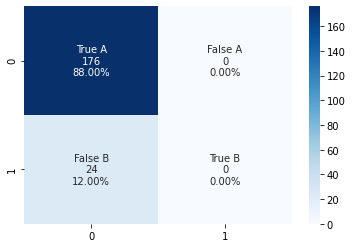

In [121]:
cf_matrix = confusion_matrix(y_test, predictions)
group_names = ['True A', 'False A',
               'False B', 'True B']

group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

### 7- Conclusion

1. How good are my predictions?
Good accuracy score of 88%, but it predicts that all films get rented 100% of the time even though it predicts it only to 88%.

2. What am I actually predicting here? What do I want to achieve with these predictions?
I am predicting if a  film will be rented in the next month or not based on the rentals of the last month.

3. Have I chosen my data wisely? (garbage in - garbage out)
high imbalance in the dataset (high number of not rented in previous month, low number of rented ones in previous month)
Do I need to normalize/scale the numerical data columns? As the accuracy score is quite high, this is not necessary right?

4. Thoughts on how to improve the model?
Incluce rents of all previous months too increase data set for more precise predictions?